

```
# Setup
```

In [ ]:
!nvidia-smi # runtime T4 GPU ашиглана

# --- Гол libraries суулгах
!pip -q install -U "transformers[torch]" datasets accelerate peft sentencepiece evaluate rouge_score bitsandbytes wandb

# --- Import test хийх, version -г хэвлэх
import torch, transformers, datasets, peft, evaluate
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("PEFT:", peft.__version__)



Tue Oct 28 04:36:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# --- Hugginface -руу нэтврэх
from huggingface_hub import login
login()

# preprocess хийхийн өмнө schema -г бататгах
Load & inspect dataset

In [ ]:
from datasets import load_dataset

# 1) Load all splits
ds = load_dataset("amaraaa/mn_translated_cnn_extended")
print(ds)

# 2) Train split -ээс хэдэн мөрүүдийг шалгая
for i in range(2):
  row = ds["train"][i]
  print(f"nRow {i} keys:", row.keys())
  print("id:", row["id"])
  print("article snippet:", (row["article"] or "")[:200].replace("\n"," "))
  print("highlights (type/len):", type(row["highlights"]).__name__, len(row["highlights"]))
  print("first highlight:", row["highlights"][0] if row["highlights"] else "-")

# 3) Sanity checks - Алдаанаас сэргийлж шалгалт хийх (data sanity checks)
def summarize_split(name):
  d = ds[name]
  # Хоосон article байгаа эсэхийг шалгах
  empty_articles = sum(1 for r in d if not r["article"] or not r["article"].strip())
  # Хоосон highlights байгаа эсэхийг шалгах
  empty_highlights = sum(1 for r in d if not r"highlights" or not r["highlights".strip()])
  return {
      "rows": len(d),
      "empty_articles": empty_articles,
      "empty_highlights": empty_highlights,
  }

print("\nSanity:")
for split in ds.keys():
  print(split, summarize_split(split))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/559 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/7.08M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/380k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/367k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1862 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/106 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/95 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 1862
    })
    validation: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 106
    })
    test: Dataset({
        features: ['id', 'article', 'highlights'],
        num_rows: 95
    })
})
nRow 0 keys: dict_keys(['id', 'article', 'highlights'])
id: 0000800d9058217f6509d7e63ad475e2de0da611
article snippet: . Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 настай асран хамгаалагч Ким Тейлор машинаас гал болон өтгөн хар ут
highlights (type/len): list 5
first highlight: 54 настай Ким Тейлор төхөөрөмжөө Ford Mondeo машины арын суудалд залгаад орхижээ.
nRow 1 keys: dict_keys(['id', 'article', 'highlights'])
id: 0000bf554ca24b0c72178403b54c0cca62d9faf8
article snippet: . Алекс Уорд. Баян хөрөнгө оруулагчдаас олон сая фунт стерлинг залилсан хотын худалдаачин өчигдөр нэг фунт сте

# Build preprocessing - (model training -д зориулж өгөгдлийг бэлдэх)
* mT5 нь single target string хүлээж авдаг
* highlights -д мөр бүрт string list байгаа

1) Иймээс list -ийн агуулгыг newline -тай нэг text болгоно
2) inputs/targets -ийг tokenize хийнэ (consistent max lengths)

In [ ]:
from datasets import DatasetDict
from transformers import AutoTokenizer

# --- Тохируулга хийх
model_name = "google/mt5-small"
task_prefix = "summarize: " # t5 model -д ямар таск хийхийг prefix зааж өгнө
max_source_length = 768
max_target_length = 128

# 1) Highlight -уудын list -ийг single string болгож join хийх
def join_highlights(example): # (example -> single record)
  bullets = example.get("highlights") or []
  # keep only non-empty strings and strip whitespace
  bullets = [str(x).strip() for x in bullets if isinstance(x, str) and str(x).strip()]
  example["highlights_str"] = "\n".join(bullets)
  # print(example)
  return example

# Функцийг split бүрийн record дээр ажилуулна
ds = ds.map(join_highlights, desc="Joining highlight bullets")

# 2) Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 3) Tokenize inputs & targets - (article, highlights)
def preprocess_batch(batch):
  # input text + task hint
  inputs = [task_prefix + (article or "") for article in batch["article"]]
  targets = batch["highlights_str"]

  # tokenize sources
  model_inputs = tokenizer(
      inputs,
      max_length=max_source_length,
      truncation=True,
  )

  # tokenize targets (labels)
  labels = tokenizer(
      text_target=targets,
      max_length=max_target_length,
      truncation=True,
  )

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

# cols_to_remove = list(set(ds["train"].column_names) - {"id"})
# Remove original columns and the joined highlights string, including 'id'
cols_to_remove = ["id", "article", "highlights", "highlights_str"]

tokenized_ds = ds.map(
    preprocess_batch,
    batched=True,
    remove_columns=cols_to_remove,
    desc="Tokenizing"
)

print(tokenized_ds)
print("Example ids:", tokenized_ds["train"][0]["input_ids"][:20], "...")
print("Example labels:", tokenized_ds["train"][0]["labels"][:20], "...")

# --- Tokenized хослолыг шалгах
sample = tokenized_ds["train"][0]
print(tokenizer.decode(sample["input_ids"][:128], skip_special_tokens=True))

# Safe label preview: (replace -100 with pad id before decoding)
safe_labels = [(tid if tid != -100 else tokenizer.pad_token_id) for tid in sample["labels"]]
print(tokenizer.decode(safe_labels[:64], skip_special_tokens=True))



Joining highlight bullets:   0%|          | 0/1862 [00:00<?, ? examples/s]

Joining highlight bullets:   0%|          | 0/106 [00:00<?, ? examples/s]

Joining highlight bullets:   0%|          | 0/95 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Tokenizing:   0%|          | 0/1862 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/106 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/95 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1862
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 95
    })
})
Example ids: [196098, 10701, 267, 259, 260, 1936, 176023, 902, 688, 94817, 237497, 260, 259, 96430, 902, 259, 68991, 129424, 990, 17157] ...
Example labels: [7013, 310, 85482, 1035, 1104, 1454, 1011, 104221, 16661, 605, 72599, 17159, 31915, 10241, 61397, 268, 259, 50835, 259, 20903] ...
summarize: . Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 настай асран хамгаалагч Ким Тейлор машинаас гал болон өтгөн хар утаа гарч байгааг анзаарахаасаа өмнө аравхан минутын турш төхөөрөмжийг цэнэглэж орхижээ. Тухайн үед дотор нь хэн ч байгаагүй ч арын суудал бүрэн 
54 

# Load mT5-small & attach LoRa adapters
LoRa гэх мэт PEFT method -оор model сургахдаа бэлдэх (peft configuration)

LoRa -> суурь model -ийг бүхэлд нь биш зөвхөн тодорхой цөөн weight -үүдийг сургана.
*   Resrource бага шаардана
*   Илүү efficient байх боломжтой
*   Model -ийн цөөн тооны parameter -ийг үр дүнтэй fine-tune хийнэ.
*   Computational болон storage cost багасгана.


In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model, TaskType

#1) Load base model
base_model_name = "google/mt5-small"
model = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)

# --- after loading tokenizer/model ---
# For T5-family, set these explicitly:
model.config.decoder_start_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.gradient_checkpointing_enable()

#2) (recommended for memory) - enable gradient checkpointing later during training
model.config.use_cache = False
# model.config.decoder_start_token_id = tokenizer.pad_token_id

#3) LoRa config тохируулах
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=16, # rank
    lora_alpha=32, #scaling
    lora_dropout=0.1, # regularization
    target_modules=["q", "v"], # T5 attention
    bias="none",
)

#4) Model -д LoRa technique -ийг apply хийнэ
model = get_peft_model(model, peft_config)

# Enable input gradients for gradient checkpointing
model.enable_input_require_grads()

# Move the model to the GPU
model.to("cuda")
print(next(model.parameters()).device)

#3) LoRa config тохируулах
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=16, # rank
    lora_alpha=32, #scaling
    lora_dropout=0.1, # regularization
    target_modules=["q", "v"], # T5 attention
    bias="none",
)

#4) Model -д LoRa technique -ийг apply хийнэ
model = get_peft_model(model, peft_config)

#5) Хэчнээн params сургахаа харах
model.print_trainable_parameters()

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

cuda:0
trainable params: 688,128 || all params: 300,864,896 || trainable%: 0.2287


In [ ]:
# 2) Sentinel blocklist үүсгэх (T5 extra_id 0..99) -> for generation
vsize = tokenizer.vocab_size
extra_ids = list(range(vsize - 100, vsize))
bad_words_ids = [[i] for i in extra_ids]
print(f"Blocking {len(bad_words_ids)} sentinel IDs: {extra_ids[0]}..{extra_ids[-1]}")

# After building bad_words_ids
model.generation_config.bad_words_ids = bad_words_ids

Blocking 100 sentinel IDs: 250000..250099


# Trainer тохируулга (metrics, collator, hyperparams)
Rouge metrics, batching/padding, hyperparameters тохируулах


In [ ]:
import numpy as np
import evaluate
from transformers import(
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
)

#1) Metric: ROUGE
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
  # strip хийгээд sentence хоороod newline нэмэх
  preds = [p.strip() for p in preds]
  labels = [l.strip() for l in labels]
  return preds, labels

def compute_metrics(eval_pred):
  preds, labels = eval_pred

  # Some trainers return (sequences)
  if isinstance(preds, tuple):
      preds = preds[0] #take token IDs matrix

  # IMPORTANT: decode хийхээс өмнө ignore index (-100) -г real pad token ID -аар солих
  #preds
  if isinstance(preds, np.ndarray):
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
  else:
    # fallback in case preds is a list
    preds = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in preds]
  #labels
  if isinstance(labels, np.ndarray):
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  else:
    # fallback in case labels is a list
    labels = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in labels]

  # print("Debugging: (computer_metrics) ")
  # print("Type of preds:", type(preds))
  # print("Preds -> first 50 values", preds[:50])
  # print("---------------------------------")

  # decode predictions
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  print(decoded_preds)

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # light cleanup for ROUGE
  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  # Compute ROUGE
  result = rouge.compute(
      predictions=decoded_preds,
      references=decoded_labels,
      use_stemmer=True,
  )

  # # add a smiple generation length metric
  # gen_lens = [np.count_nonzero(p != tokenizer.pad_token_id) for p in preds]
  # result["gen_len"] = float(np.mean(gen_lens))
  # # focus metric alias
  # result["rougeLsum"] = result.get("rougeLsum", result.get("rougeL", 0.0))
  # return {k: round(v * 100, 4) if k.startswith("rouge") else round(v, 2) for k, v in result.items()}

  return {k: round(v * 100, 4) for k, v in result.items()}

#2) dynamic padding & label masking (-100)
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100,
    pad_to_multiple_of=8 if torch.cuda.is_available() else None,
)

#3) Enable memory savers
model.gradient_checkpointing_enable() # reduces VRAM

#4) Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="mt5_mncnn_lora",
    per_device_train_batch_size=4, #GPU дээр нэг удаад хэр их sample process хийхийг тодорхойлно
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=5e-4, #LoRa -д тохиромжтой learning rate (1e-4 -> 5e-4)
    num_train_epochs=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=4, #давтамжийг багасгана, үр дүнг сайжруулна.
    warmup_ratio=0.03, #сургалтын явцад learning rate -ийг ихэсгэнэ
    lr_scheduler_type="linear",
    weight_decay=0.01, #overfitting үүсэхээс сэргийлнэ. data pattern -ийг сурахад илүү туслана.
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_rougeLsum",
    greater_is_better=True,
    fp16=False,
    report_to="none",
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Add early stopping (prevents overfitting on 369 rows)
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))

print("Ready to train.")
print("Train rows:", len(tokenized_ds["train"]), "| Val rows:", len(tokenized_ds["validation"]))

Ready to train.
Train rows: 1862 | Val rows: 106


/tmp/ipython-input-3713865135.py:114: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


# Sanity check before full training

In [ ]:
# Small slice of eval to test metrics & decoding path
small_eval = tokenized_ds["validation"].select(range(20))
eval_result = trainer.evaluate(eval_dataset=small_eval)

print(eval_result)


['itse.netгийнх нь нийтэд нь нийтэд', '....” гэж үүгээр нь нэмэгдүүлсэн.)', 'moji гэжээ့္ловнад. /././', 'itseловна /. . )... . . )', 'იaaуланkcidentуланக்கீуланlytte⸢уланlytte', 'itseулан', 'waулан', 'itse: нь нь нь нь нь нь нь нь дээр нь үед дээр үед нь энэ амьдрах нь энэ үед нь түүнийг нь эзэ дээрээс нь эзэ дээрээс нь эзэ дээрээс нь эзэ нь эзэ нь эзэ нь эзэ нь эзэ нь нь түүний эзэ нь нь түүний эзэ нь нь нь', 'itsendiricindirici.Хүмүүс', 'wa⸢уланӈan ', 'wa {"_ෝරriogogo.com.--rb.me \'улан олж олж авах-ын-хэм олгох.paab арай дээрхиртуигийн-буужрах  нүүрсээр уваход юу анхаарахгүй байна. sээр олгодог гэжүү юуртуижирчээ. х... гаас', 'moji . . . . . .', 'wa⸢улан', 'waуланlytte', 'itseкүловна байна.Хүрэлсүхэд гэмтээжээndiricindiricindiricindiricindiricindiricindiricindiricindiricindiricindiricindiriciловнаs', 'waуланулан', '....”дنظر.: . .)', 'itseловнаh /. . . /.', 'waуланismiss⸢', '....” нь. нь. /д үгэнд байна. /']
{'eval_loss': 10.768037796020508, 'eval_model_preparation_time': 0.0069, '

# Training эхлүүлэх - (LoRa on mT5-small)

In [ ]:
# # ──────────────────────────────────────────────────────────────
# # 8) Evaluate → Train → Evaluate
# # ──────────────────────────────────────────────────────────────
print("Eval (before training):")
metrics_before = trainer.evaluate()
print(metrics_before)

# Training
train_result = trainer.train()

# best checkpoint -ийг хадгалж авна
trainer.save_model("mt5_mncnn_lora/best") # saves LoRa adapter weights + config
tokenizer.save_pretrained("mt5_mncnn_lora/best")

# Traning үр дүн
print(train_result)

Epoch,Training Loss,Validation Loss,Model Preparation Time,Rouge1,Rouge2,Rougel,Rougelsum
1,5.471300,2.879493,0.006900,8.214200,1.693300,8.219500,8.339200
2,4.075500,2.801159,0.006900,10.372100,2.201300,10.222200,10.458900
3,3.868900,2.796531,0.006900,13.548500,2.890700,13.334900,13.544000
4,3.808500,2.795620,0.006900,13.243100,3.443400,13.082900,13.184300
5,3.766900,2.759410,0.006900,12.930300,4.185400,12.684800,12.715900


['urah Sky Sports Box Office сувгаараа худалдан авалт хийхдээ 19.95 фунт стерлинг байхаар тогтоосон. Тэд энэ улсын үзвэрийн төлбөр санал болгосон гэж үзэж байна. Мэйведер түүхэн дэх хамгийн баян тулаан Sky Sports сувгаараа худалдан авалт хийх ёстой гэж үзэж байна. Мэйведер энэ улсын үзвэрийн төлбөр санал болгосон гэж үзэж байна. Мэйведер энэ улсын рекордыг эвдэх ёстой гэж үзэж байна.', 'אָר. Уна Краун гэр бүл болон хөршүүд нь түүний амийг хөнөөсөн байсныг цагдаагийн ажилтнууд олж илрүүлсэнгүй. Тэтгэвэрт гарсан шуудангийн эзэгтэй хатагтай Уна Краун гэр бүл болон хөршүүд нь цагдаагийн ажилтнууд олж илрүүлсэнгүй. Тэтгэвэрт гарсан шуудангийн эзэгтэй хатагтай Крауны зээ охин Жудит Пэйнс шүүх хуралдаанд хэлэв. Тэтгэвэрт гар', 'urah нь Европын дээд амжилтыг эвдэж, Лиссабоны хагас марафонд 60 минутаас бага хугацаанд уралдсан. Энэ жил хоёр уралдаан нь Европын дээд амжилтыг эвдэж, Лиссабоны хагас марафонд 60 минутаас бага хугацаанд уралдсан. Энэ жил хоёр уралдаандаа Европын дээд амжилтыг эвдэж, 

In [ ]:
# Small slice of eval to test metrics & decoding path
test_eval = tokenized_ds["test"]
eval_result = trainer.evaluate(eval_dataset=test_eval)

print(eval_result)

['<extra_id_0> .', '<extra_id_0>.', '<extra_id_0>. . . . . . . . . . . .', '<extra_id_0> .', '<extra_id_0> байна.', '<extra_id_0> . Скармардо . Скармардо . Скармардо . Скармардо . Скармардо . Скармардо . Скармардо . Скармардо . Скармардо . Скармардо . Скармардо .', '<extra_id_0> байдаг.', '<extra_id_0>.', '<extra_id_0> байдаг.', '<extra_id_0>.com-д.mn', '<extra_id_0> байдаг. . 21:22 EST, 3 9-р сарын 2012 . 21:22 EST, 3 9-р сарын 2012 .', '<extra_id_0>.com-д.mx', '<extra_id_0> .', '<extra_id_0>. . . . . . . . . . . .', '<extra_id_0>гүй.', '<extra_id_0> байдаг юм.', '<extra_id_0>гүй байна. (CNN)', '<extra_id_0> байдаг.', '<extra_id_0> менежер юм.', '<extra_id_0>.com-д.']
{'eval_loss': 14.388493537902832, 'eval_model_preparation_time': 0.0068, 'eval_rouge1': 0.0, 'eval_rouge2': 0.0, 'eval_rougeL': 0.0, 'eval_rougeLsum': 0.0, 'eval_runtime': 4.9867, 'eval_samples_per_second': 4.011, 'eval_steps_per_second': 1.003}


In [ ]:
!pip install matplotlib

import matplotlib.pyplot as plt
import pandas as pd

# 1. Filter the relevant metrics for visualization (e.g., exclude runtime stats)
metrics_to_plot = {
    'Loss': eval_result['eval_loss'],
    'Rouge 1': eval_result['eval_rouge1'],
    # 'Rouge 2': eval_result['eval_rouge2'],
    # 'Rouge L': eval_result['eval_rougeL'],
    'Rouge Lsum': eval_result['eval_rougeLsum']
}

# 2. Extract keys (metric names) and values (scores)
names = list(metrics_to_plot.keys())
values = list(metrics_to_plot.values())

# 3. Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(names, values, color=['blue', 'green', 'orange'])
plt.ylabel('Score/Value')
plt.title('mT5 Fine-tuned Model Test Set Evaluation Results')
plt.ylim(0, 1.1) # Adjust y-axis limit for better visibility of scores (0 to 1 range for accuracy/f1)

# Optional: Add the exact value on top of each bar
for i, value in enumerate(values):
    plt.text(i, value + 0.05, f"{value:.4f}", ha='center')

plt.show()


In [ ]:
# Сургасан model -оо хадгалах

#1) Google Drive -руу хадгалах
SAVE_DIR = "/content/drive/MyDrive/mt5_summarization_mn_v1"

from google.colab import drive
drive.mount('/content/drive')

trainer.save_model(SAVE_DIR) # with PEFT: saves LoRA adapter + peft_config.json
tokenizer.save_pretrained(SAVE_DIR) # tokenizer files
model.config.save_pretrained(SAVE_DIR)
print("Saved to:", SAVE_DIR)


Mounted at /content/drive
Saved to: /content/drive/MyDrive/mt5_summarization_mn_v1


# Merge LoRA → base weights locally and self-test

In [ ]:
from peft import PeftConfig
from pathlib import Path

ADAPTER_DIR = "mt5_mncnn_lora/best"     # <-- change if yours is different
MERGED_DIR  = "mt5_mncnn_merged"

peft_cfg = PeftConfig.from_pretrained(ADAPTER_DIR)
BASE_ID = peft_cfg.base_model_name_or_path
print("Base model recorded in adapter:", BASE_ID)
Path(MERGED_DIR).mkdir(parents=True, exist_ok=True)

Base model recorded in adapter: google/mt5-small


# Load base, attach adapter, merge and unload

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel

def pick_dtype():
    if torch.cuda.is_available():
        major, _ = torch.cuda.get_device_capability(0)
        return torch.bfloat16 if major >= 8 else torch.float16  # bf16 on Ampere+; else fp16
    return torch.float32

dtype = pick_dtype()

base = AutoModelForSeq2SeqLM.from_pretrained(BASE_ID, torch_dtype=dtype)
tok  = AutoTokenizer.from_pretrained(ADAPTER_DIR)  # prefer your saved tokenizer
model = PeftModel.from_pretrained(base, ADAPTER_DIR)

# The key step:
merged = model.merge_and_unload()   # applies LoRA deltas into base weights in-place
merged.eval()

`torch_dtype` is deprecated! Use `dtype` instead!


MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

# Save merged model (+ tokenizer + generation config)

In [ ]:
# Save weights/config
merged.save_pretrained(MERGED_DIR)

# Tokenizer
tok.save_pretrained(MERGED_DIR)

# Generation config (if present on the current model)
try:
    merged.generation_config.save_pretrained(MERGED_DIR)
    print("Saved generation_config.json")
except Exception as e:
    print("No generation_config to save:", e)

Saved generation_config.json


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

MERGED_DIR = "mt5_mncnn_merged"  # <- change if different
device = "cuda" if torch.cuda.is_available() else "cpu"

tok = AutoTokenizer.from_pretrained(MERGED_DIR)          # <-- important: use your saved tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(MERGED_DIR).to(device).eval()

print("pad:", tok.pad_token, tok.pad_token_id, "eos:", tok.eos_token, tok.eos_token_id)


pad: <pad> 0 eos: </s> 1


In [ ]:
from transformers import GenerationConfig

gen = getattr(model, "generation_config", GenerationConfig())
changed = False

if gen.pad_token_id is None:
    gen.pad_token_id = tok.pad_token_id; changed = True
if gen.eos_token_id is None:
    gen.eos_token_id = tok.eos_token_id; changed = True
# T5 convention: decoder starts from pad token
if gen.decoder_start_token_id is None:
    gen.decoder_start_token_id = tok.pad_token_id; changed = True

if changed:
    gen.save_pretrained(MERGED_DIR)
    print("Saved/updated generation_config.json")
else:
    print("Generation config already had the right IDs.")


Generation config already had the right IDs.


In [ ]:
# Build a bad_words list for all sentinel tokens so they can’t appear in generation
# bad_tokens = [f"<extra_id_{i}>" for i in range(100)]
# bad_ids = tok.convert_tokens_to_ids(bad_tokens)
# bad_ids = [[i] for i in bad_ids if i != tok.unk_token_id and i is not None]

vsize = tokenizer.vocab_size
extra_ids = list(range(vsize - 100, vsize))
bad_ids = [[i] for i in extra_ids]
print(f"Blocking {len(bad_words_ids)} sentinel IDs: {extra_ids[0]}..{extra_ids[-1]}")

# Attach to generation_config and save for future runs
from transformers import GenerationConfig
gen = GenerationConfig.from_pretrained(MERGED_DIR) if (MERGED_DIR) else GenerationConfig()
gen.bad_words_ids = (gen.bad_words_ids or []) + bad_ids
gen.save_pretrained(MERGED_DIR)
print(f"Blocked {len(bad_ids)} sentinel tokens.")


Blocking 100 sentinel IDs: 250000..250099
Blocked 100 sentinel tokens.


In [ ]:
def summarize(text, max_input_len=768, max_new_tokens=96):
    prompt = "summarize: " + text.strip()
    inputs = tok(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_len,  # raise to 768 if VRAM allows; mT5-small can handle it
    ).to(device)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=4,                # stable, deterministic
            length_penalty=1.0,
            no_repeat_ngram_size=3,
            early_stopping=True,
        )
    return tok.decode(out[0], skip_special_tokens=True)

test_text = "Энэ жилийн хамгийн хүчтэй хар салхи Ямайка аралд буух гэж байна. Тодруулбал, 282км цаг хүртэл хүчтэй салхилсан тавдугаар зэрэглэлийн аймшигт Мелисса хар салхи Мягмар гариг (2025.10.28) гэхэд арал дээр бууна гэж мэргэжилтнүүд мэдэгдэж байв. Энэ хар салхи Ямайкийн түүхэнд бүртгэгдсэн хамгийн хүчтэй байж магадгүй юм. "
print(summarize(test_text))


<extra_id_0> дээр бууна гэж мэргэжилтнүүд мэдэгдэж байв. Энэ жилийн хамгийн хүчтэй хар салхи Ямайка аралд буух гэж байна.


Quick Local Test

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
merged = AutoModelForSeq2SeqLM.from_pretrained(MERGED_DIR, torch_dtype=dtype).to(device)
tok    = AutoTokenizer.from_pretrained(MERGED_DIR)

prompt = "summarize: Энэ жилийн хамгийн хүчтэй хар салхи Ямайка аралд буух гэж байна. Тодруулбал, 282км цаг хүртэл хүчтэй салхилсан тавдугаар зэрэглэлийн аймшигт Мелисса хар салхи Мягмар гариг (2025.10.28) гэхэд арал дээр бууна гэж мэргэжилтнүүд мэдэгдэж байв. Энэ хар салхи Ямайкийн түүхэнд бүртгэгдсэн хамгийн хүчтэй байж магадгүй юм. "
inputs = tok(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)

with torch.no_grad():
    out = merged.generate(**inputs, max_new_tokens=64)
print(tok.decode(out[0], skip_special_tokens=True))

長の Мелисса хар салхи Ямайка аралд буух гэж байна.


In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM

ADAPTER_DIR = "mt5_mncnn_lora/best"

# Load adapter path to discover the base
peft_cfg = PeftConfig.from_pretrained(ADAPTER_DIR)
base = AutoModelForSeq2SeqLM.from_pretrained(peft_cfg.base_model_name_or_path).to(device).eval()
model_lora = PeftModel.from_pretrained(base, ADAPTER_DIR).to(device).eval()

def summarize_with(model_obj, text):
    prompt = "summarize: " + text.strip()
    ins = tok(prompt, return_tensors="pt", truncation=True, max_length=768).to(device)
    with torch.no_grad():
        out = model_obj.generate(
            **ins,
            max_new_tokens=96,
            num_beams=4,
            length_penalty=1.0,
            no_repeat_ngram_size=3,
            early_stopping=True,
        )
    return tok.decode(out[0], skip_special_tokens=True)

print("MERGED:", summarize_with(model, test_text))
print("ADAPTER:", summarize_with(model_lora, test_text))


MERGED: <extra_id_0> дээр бууна гэж мэргэжилтнүүд мэдэгдэж байв. Энэ жилийн хамгийн хүчтэй хар салхи Ямайка аралд буух гэж байна.
ADAPTER: <extra_id_0> дээр бууна гэж мэргэжилтнүүд мэдэгдэж байв. Энэ жилийн хамгийн хүчтэй хар салхи Ямайка аралд буух гэж байна.


In [ ]:
import os, glob
MERGED_DIR = "mt5_mncnn_merged"  # or whatever you used above
print("cwd:", os.getcwd())
print("exists:", os.path.isdir(MERGED_DIR))
print("contents (first 20):")
for p in sorted(glob.glob(f"{MERGED_DIR}/**/*", recursive=True))[:20]:
    print(" ", p)


cwd: /content
exists: True
contents (first 20):
  mt5_mncnn_merged/config.json
  mt5_mncnn_merged/generation_config.json
  mt5_mncnn_merged/model.safetensors
  mt5_mncnn_merged/special_tokens_map.json
  mt5_mncnn_merged/spiece.model
  mt5_mncnn_merged/tokenizer.json
  mt5_mncnn_merged/tokenizer_config.json


In [ ]:
# Either CLI (in a notebook cell)
# !huggingface-cli login

# Or Python:
from huggingface_hub import login
login()  # paste your HF token from https://huggingface.co/settings/tokens

In [ ]:
from huggingface_hub import upload_folder

repo_id = "amaraaa/mt5-small-summarization-mn-v1"
upload_folder(
    repo_id=repo_id,
    folder_path=MERGED_DIR,
    commit_message="Add merged mT5 Mongolian summarization model",
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mncnn_merged/spiece.model: 100%|##########| 4.31MB / 4.31MB            

  ...cnn_merged/tokenizer.json:   3%|3         |  529kB / 16.3MB            

  ..._merged/model.safetensors:   3%|2         | 15.6MB /  617MB            

CommitInfo(commit_url='https://huggingface.co/amaraaa/mt5-small-summarization-mn-v1/commit/aa1d21791a06f77550d5a350d00c8ca398130671', commit_message='Add merged mT5 Mongolian summarization model', commit_description='', oid='aa1d21791a06f77550d5a350d00c8ca398130671', pr_url=None, repo_url=RepoUrl('https://huggingface.co/amaraaa/mt5-small-summarization-mn-v1', endpoint='https://huggingface.co', repo_type='model', repo_id='amaraaa/mt5-small-summarization-mn-v1'), pr_revision=None, pr_num=None)

# Graphs

In [1]:
!pip -q install -U datasets sentencepiece evaluate rouge_score

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_id = "amaraaa/mt5-small-summarization-mn-v1"  # e.g. "amaraaa/mt5-base-summarization-mn-v1"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
model.eval()


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.8 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/416 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/617M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
          

In [2]:
from datasets import load_dataset

dataset_id = "amaraaa/mn_translated_cnn_extended"  # e.g. "amaraaa/mn_translated_cnn_extended"
ds = load_dataset(dataset_id)

# test_dataset_raw = raw_datasets["test"]


README.md:   0%|          | 0.00/606 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/7.08M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/380k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/367k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1862 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/106 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/95 [00:00<?, ? examples/s]

In [7]:
# 2) Sentinel blocklist үүсгэх (T5 extra_id 0..99) -> for generation
vsize = tokenizer.vocab_size
extra_ids = list(range(vsize - 100, vsize))
bad_words_ids = [[i] for i in extra_ids]
print(f"Blocking {len(bad_words_ids)} sentinel IDs: {extra_ids[0]}..{extra_ids[-1]}")

# After building bad_words_ids
model.config.decoder_start_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.generation_config.bad_words_ids = bad_words_ids

Blocking 100 sentinel IDs: 250000..250099


In [3]:
from datasets import DatasetDict
from transformers import AutoTokenizer

# --- Тохируулга хийх
task_prefix = "summarize: " # t5 model -д ямар таск хийхийг prefix зааж өгнө
max_source_length = 768
max_target_length = 128

# 1) Highlight -уудын list -ийг single string болгож join хийх
def join_highlights(example): # (example -> single record)
  bullets = example.get("highlights") or []
  # keep only non-empty strings and strip whitespace
  bullets = [str(x).strip() for x in bullets if isinstance(x, str) and str(x).strip()]
  example["highlights_str"] = "\n".join(bullets)
  # print(example)
  return example

# Функцийг split бүрийн record дээр ажилуулна
ds = ds.map(join_highlights, desc="Joining highlight bullets")

# 3) Tokenize inputs & targets - (article, highlights)
def preprocess_batch(batch):
  # input text + task hint
  inputs = [task_prefix + (article or "") for article in batch["article"]]
  targets = batch["highlights_str"]

  # tokenize sources
  model_inputs = tokenizer(
      inputs,
      max_length=max_source_length,
      truncation=True,
  )

  # tokenize targets (labels)
  labels = tokenizer(
      text_target=targets,
      max_length=max_target_length,
      truncation=True,
  )

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

# cols_to_remove = list(set(ds["train"].column_names) - {"id"})
# Remove original columns and the joined highlights string, including 'id'
cols_to_remove = ["id", "article", "highlights", "highlights_str"]

tokenized_ds = ds.map(
    preprocess_batch,
    batched=True,
    remove_columns=cols_to_remove,
    desc="Tokenizing"
)

print(tokenized_ds)
print("Example ids:", tokenized_ds["train"][0]["input_ids"][:20], "...")
print("Example labels:", tokenized_ds["train"][0]["labels"][:20], "...")

# --- Tokenized хослолыг шалгах
sample = tokenized_ds["train"][0]
print(tokenizer.decode(sample["input_ids"][:128], skip_special_tokens=True))

# Safe label preview: (replace -100 with pad id before decoding)
safe_labels = [(tid if tid != -100 else tokenizer.pad_token_id) for tid in sample["labels"]]
print(tokenizer.decode(safe_labels[:64], skip_special_tokens=True))



Joining highlight bullets:   0%|          | 0/1862 [00:00<?, ? examples/s]

Joining highlight bullets:   0%|          | 0/106 [00:00<?, ? examples/s]

Joining highlight bullets:   0%|          | 0/95 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/1862 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/106 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/95 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1862
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 95
    })
})
Example ids: [196098, 10701, 267, 259, 260, 1936, 176023, 902, 688, 94817, 237497, 260, 259, 96430, 902, 259, 68991, 129424, 990, 17157] ...
Example labels: [7013, 310, 85482, 1035, 1104, 1454, 1011, 104221, 16661, 605, 72599, 17159, 31915, 10241, 61397, 268, 259, 50835, 259, 20903] ...
summarize: . Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 настай асран хамгаалагч Ким Тейлор машинаас гал болон өтгөн хар утаа гарч байгааг анзаарахаасаа өмнө аравхан минутын турш төхөөрөмжийг цэнэглэж орхижээ. Тухайн үед дотор нь хэн ч байгаагүй ч арын суудал бүрэн 
54 

In [8]:
import numpy as np
import evaluate
from transformers import(
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
)

#1) Metric: ROUGE
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
  # strip хийгээд sentence хоороod newline нэмэх
  preds = [p.strip() for p in preds]
  labels = [l.strip() for l in labels]
  return preds, labels

def compute_metrics(eval_pred):
  preds, labels = eval_pred

  # Some trainers return (sequences)
  if isinstance(preds, tuple):
      preds = preds[0] #take token IDs matrix

  # decode хийхээс өмнө ignore index (-100) -г real pad token ID -аар солих
  #preds
  if isinstance(preds, np.ndarray):
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
  else:
    # fallback in case preds is a list
    preds = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in preds]
  #labels
  if isinstance(labels, np.ndarray):
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  else:
    # fallback in case labels is a list
    labels = [[(tok if tok != -100 else tokenizer.pad_token_id) for tok in seq] for seq in labels]

  # decode predictions
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  print(decoded_preds)

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # light cleanup for ROUGE
  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  # Compute ROUGE
  result = rouge.compute(
      predictions=decoded_preds,
      references=decoded_labels,
      use_stemmer=True,
  )

  return {k: round(v * 100, 4) for k, v in result.items()}

#2) dynamic padding & label masking (-100)
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100,
    # pad_to_multiple_of=8 if torch.cuda.is_available() else None,
)

#3) Enable memory savers
model.gradient_checkpointing_enable() # reduces VRAM

#4) Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./tmp_eval",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=4, #давтамжийг багасгана, үр дүнг сайжруулна.
    report_to="none",
    do_train=False,
    do_eval=False,
    do_predict=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# metrics = trainer.evaluate()
# print(metrics)


/tmp/ipython-input-2201932536.py:82: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [9]:
# Validation eval
valid_eval = tokenized_ds["validation"]
best_valid_metrics = trainer.evaluate(eval_dataset=valid_eval)

print(best_valid_metrics)

%store best_valid_metrics

['"== Sky Sports Box Office сувгаараа худалдан авалт хийхдээ 19.95 фунт стерлинг байхаар тогтоосон. Уоррен сард 12 фунт стерлингийн үнээр энэ тоонд хүрч чадах ёстой гэж үзэж байна. Мэйведер энэ улсын рекордыг эвдэх ёстой гэж үзэж байна. Мэйведер энэ улсын рекордыг эвдэх ёстой гэж үзэж байна.', 'શ્વર Гледхилл харьцангуй эрт Уна Краун гэр бүл болон хөршүүд нь түүний амийг хөнөөсөн байсныг цагдаагийн ажилтнууд олж илрүүлсэнгүй. Тэтгэвэрт гарсан шуудангийн эзэгтэйн цогцсыг цусанд будагдсан, хувцас нь "шатсан" байсныг цагдаагийн ажилтнууд олж илрүүлсэнгүй. Тэтгэвэрт гарсан шуудангийн эзэгтэйн цогцсыг цусанд будагдсан, хувцас нь "шат', 'ықтық. Мо Фарах Европын дээд амжилтыг эвдэж, Испанийн Фабиан Ронсерогийн 14 жилийн өмнө тогтоосон амжилтаас 20 секундын зөрүүтэй давхилаа.', 'ықтық улсын гэрлийн 83 хувь нь унтарсан иргэний дайн эхэлснээс хойш Сиритэй хамт эвслийн нэг хэсэг болох олон улсын 130 төрийн бус байгууллага дэмжсэн.', '長の зураг: Охайо мужийн хуулийн дагуу сарны туяаг өөрт нь үзүүлэх

In [10]:
# Test eval
test_eval = tokenized_ds["test"]
eval_result = trainer.evaluate(eval_dataset=test_eval)

print(eval_result)

['長の Хуан Аранго Луис Суаресыг Мексикт болсон тоглолтод Мексикт болсон тоглолтод Аранго Мексикт болсон тоглолтод Мексикт болсон. Аранго Мексикт болсон тоглолтод Мексикт болсон тоглолтод Мексикт болсон тоглолтод Мексикт болсон тоглолтод Мексикт болсон тоглолтод Мексикт болсон. Аранго Мексикт болсон тоглолтод Мексикт болсон тоглолтод Мексикт болсон', 'શ્વર Гарднер Сити Граунд Уотфордод хожигдох үеэр Виллагийн академид элссэн. Гарднер Сити Граунд Уотфордод хожигдох үеэр Виллагийн босс томилогдсоноосоо хойш Сити Граунд Уотфордод хожигдох үеэр Виллагийн босс томилогдсоноосоо хойш Сити Граунд Уотфордод хожигдох үеэр Виллагийн босс томилогдсоноос хойш Сити Граунд Уотфордод хожигдох үеэр Виллагийн', 'ықтық анагаах ухааны мэргэжилтнүүд хэт бага давсны хор хөнөөлийн талаар анхааруулсаар ирсэн боловч шинэ судалгаагаар хэт бага давсны хор хөнөөлийн талаар анхааруулсаар ирсэн. Олон жилийн турш анагаах ухааны мэргэжилтнүүд хэт бага давсны хор хөнөөлийн талаар анхааруулсаар ирсэн боловч шинэ судалгаа

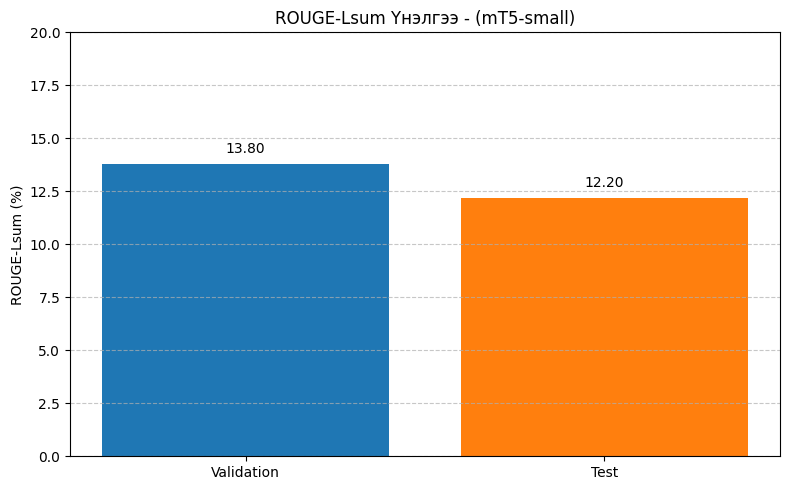

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Retrieve the globally stored best_validation_metrics
# We assume eval_result is from the test set evaluation and is available in the current scope

# Extract RougeLsum for comparison
val_rougeLsum = best_valid_metrics['eval_rougeLsum']
test_rougeLsum = eval_result['eval_rougeLsum']

# Data for plotting
metrics_data = {
    'Metric': ['Validation', 'Test'],
    'Score': [val_rougeLsum, test_rougeLsum]
}
df_comparison = pd.DataFrame(metrics_data)

# Create the bar chart
plt.figure(figsize=(8, 5))
bar_colors = ['#1f77b4', '#ff7f0e'] # Different colors for distinction
plt.bar(df_comparison['Metric'], df_comparison['Score'], color=bar_colors)

plt.ylabel('ROUGE-Lsum (%)')
plt.title('ROUGE-Lsum Үнэлгээ - (mT5-small)')
plt.ylim(0, 20) # Adjust y-axis limit based on expected ROUGE scores

# Optional: Add the exact value on top of each bar
for index, row in df_comparison.iterrows():
    plt.text(row['Metric'], row['Score'] + 0.5, f"{row['Score']:.2f}", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()